In [2]:
import pandas as pd
import numpy as np
import ast
import datetime
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

css_style="""<style>
    table {
      border-collapse: collapse;
      
    }

    th, td {
      text-align: center;

      padding: 8px;
    }

    tr:nth-child(even) {background-color: rgb(242, 242, 242);}

    </style>
    """

In [3]:
credentials = ast.literal_eval(open(r"C:\Users\pablo\OneDrive - unizar.es\Python Investigación\credentials.txt", "r").read())

# esg_scores DataBase
sql_engine = create_engine(credentials['sqlalchemy'][0]+ 'ESGRefinitiv')
query = """SELECT esg.monthly_date, esg.esg_score, refiv.internal_id
    FROM monthly_esg as esg
    INNER JOIN companies_esg_refinitiv AS refiv
    ON esg.datastream_id = refiv.datastream_id
    WHERE esg.esg_score IS NOT NULL"""

monthly_esg = pd.read_sql(query,sql_engine)

# companies score refinitiv
sql_engine = create_engine(credentials['sqlalchemy'][0]+ 'ESGRefinitiv')
esg_refinitiv= pd.read_sql('companies_esg_refinitiv', sql_engine)
esg_refinitiv = esg_refinitiv.loc[:,['internal_id', 'datastream_id', 'isin_code', 'worldscope_code']]
monthly_esg['year_month'] = monthly_esg['monthly_date'].dt.to_period('M')

In [4]:
sql_engine = create_engine(credentials['sqlalchemy'][0]+ 'market_index')
index_details = pd.read_sql('index_details',sql_engine)
index_details = index_details.loc[~index_details['index_ticker'].isin(['LFT4G100','LFT4U100'])]
df_results = pd.DataFrame() # results of score SW and EW
df_statics= pd.DataFrame() # details of the index 

for index_ticker, group in zip(index_details['index_ticker'], index_details['family_1']):
    
    query = sql_query(index_ticker, (2008,1,1), (2019,12,31))
    df_sust = pd.read_sql(query, sql_engine)
    # Match ESGRefinitiv wirt Index dtabase
    df_1 =df_sust.copy()
    for key in ('datastream_id', 'isin_code', 'worldscope_code'):
        df = df_1.merge(esg_refinitiv.loc[:,['internal_id',key]].dropna(), on=key, how='left')
        df_sust = df_sust.set_index(key,drop=False).combine_first(df.set_index(key).loc[:,['internal_id']])

    df_sust['year_month'] = df_sust['monthly_date'].dt.to_period('M')
    df_sust = df_sust.merge(monthly_esg, on=['internal_id','year_month'], how='inner')

    # to get descriptive stats of the index (score) 
    df_detail= df_sust.pivot_table(index='year_month', aggfunc={'esg_score':'count', 'company_weight':'sum'} )
    df_detail.index = df_detail.index.to_timestamp()
    df_detail.reset_index(inplace=True)
    df_detail['year_month'] = df_detail['year_month'].dt.to_period('Y')
    df_detail = df_detail.pivot_table(index='year_month', aggfunc={'esg_score':'mean', 'company_weight':'mean'})
    df_detail['Family']= group
    df_detail['Index'] = index_ticker
    df_detail['Analysis'] = 'Score'
    df_statics = pd.concat([df_statics, df_detail], axis=0)
    
    # get the montlhy scores of the index
    df_sust['weighted_esg_score'] = (df_sust['esg_score']* df_sust['company_weight'])
    df_sust = df_sust.pivot_table(index='year_month', aggfunc={'esg_score':'mean', 'company_weight':'sum', 
                                                    'weighted_esg_score':'sum' })
    df_sust['weighted_esg_score'] = df_sust['weighted_esg_score']*0.01
    df_sust['weighted_esg_score_corrected'] = df_sust['weighted_esg_score'] / (df_sust['company_weight']/100)
    
    
    df_sust['family'] = group
    df_sust['index_ticker']= index_ticker
    df_sust.drop(['company_weight','weighted_esg_score'], axis=1, inplace=True)
    df_results=pd.concat([df_results, df_sust], axis=0)
    
df_results = df_results.pivot_table(columns = ['family', 'index_ticker'], index='year_month', 
                       aggfunc = 'first').reorder_levels([1,2,0],axis=1).sort_index(axis=1,level=[0,1])
df_results.index = df_results.index.to_timestamp()

In [5]:
# Create the table with stats of the index (Active Share) --> Number of constituents and number of constituents with id
df_statics.rename({'company_weight': 'company_weight_score'}, axis=1, level=0, inplace=True)
for index_ticker, group in zip(index_details['index_ticker'], index_details['family_1']):
    query = sql_query(index_ticker, (2008,1,1), (2019,12,31))
    df_detail = pd.read_sql(query, sql_engine)
    df_detail = df_detail.pivot_table(index=['monthly_date'] , values =['refinitiv_type', 'datastream_id', 'company_weight'], 
                      aggfunc={'refinitiv_type':'count','datastream_id': 'count',  'company_weight':'sum'})
   
    df_detail.reset_index(inplace=True)
    df_detail['monthly_date'] = df_detail['monthly_date'].dt.to_period('Y')
    df_detail.rename({'monthly_date':'year_month'}, axis=1, inplace=True)
    df_detail = df_detail.pivot_table(index='year_month', aggfunc='mean')
    
    df_detail['Family']= group
    df_detail['Index'] = index_ticker
    df_detail['Analysis'] = 'Active Share'
    df_statics = pd.concat([df_statics, df_detail], axis=0)
    
# Change the name of the columns, round the numbers
columns = [['refinitiv_type','Companies Index', 0], ['datastream_id', 'Companies ID', 0], ['company_weight', 'Weight', 1],
           ['company_weight_score', 'Weight Score', 1], ['esg_score', 'Company Score', 0] ]
for col in columns:
    df_statics.rename({col[0]: col[1]}, axis=1, inplace=True)
    df_statics[col[1]]= df_statics[col[1]].round(col[2])
    

# Change the ticker of the index for the type of the index (conventional or sustainability)
for index, type_index in zip(index_details.index_ticker, index_details.type):
    df_statics['Index']= df_statics['Index'].replace({index: type_index})

df_statics = df_statics.pivot_table(index=['Family','year_month'], columns=['Index', 'Analysis'], aggfunc='first')
df_statics = df_statics.reorder_levels([1,2,0], axis=1).sort_index(axis=1)
# Change the order of the number variables
df_statics = df_statics.reindex([col[1] for col in columns], level=2, axis=1)  
# To html Table
Html_file= open(r"C:\Users\pablo\OneDrive - unizar.es\Tesis\Artículo 4 Sustainability Share\2. Results\2. Draft\Table 2 Descriptive Statistics.html","w")
Html_file.write(css_style + df_statics.to_html())
Html_file.close()

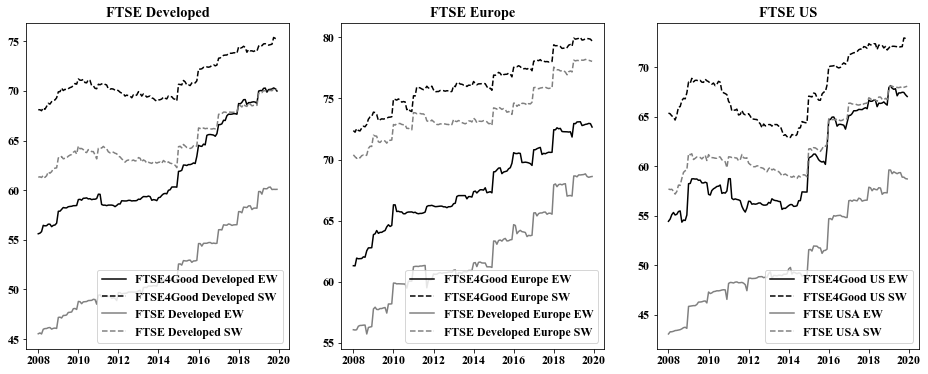

In [11]:
colors = ('black',  'grey')
names = (' EW', ' SW')
styles = ('-','--', ':')

plt.rcParams['font.family']="Times New Roman"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size']=12

# Change the ticker to the name of the provider
for provider_name, index_ticker in zip(index_details['provider_name'].to_list(), index_details['index_ticker'].to_list()):
    df_results.rename({index_ticker : provider_name}, axis=1, level=1, inplace=True)
df_results.rename({'esg_score' : 'Equally Weighted', 'weighted_esg_score_corrected':'Size Weighted' }, 
                  axis=1, level=2, inplace=True)
df_results = df_results.reindex(index_details.provider_name.to_list(), level=1, axis=1)



fig, axes = plt.subplots(ncols=3, figsize=(16,6))

for ax, group in zip(axes, pd.unique(index_details.family_1)):
    df_group = df_results.loc[:,(group)]
    for index, color in zip(pd.unique(df_group.columns.get_level_values(0)), colors):
        df_index = df_group.loc[:, (index)]
        for col, style, name in zip(df_index.columns, styles, names):
            ax.plot(df_index[col], label=index + name, c= color, linestyle= style)
        
    ax.set_title(group)
    ax.legend()  
    
fig.savefig(r"C:\Users\pablo\OneDrive - unizar.es\Tesis\Artículo 4 Sustainability Share\2. Results\2. Draft\Figure 2 Esg average and weighted.pdf", dpi=1200, 
          orientation='portrait')
fig.savefig(r"C:\Users\pablo\OneDrive - unizar.es\Tesis\Artículo 4 Sustainability Share\2. Results\2. Draft\Figure 2 Esg average and weighted.png", dpi=1200, 
          orientation='portrait')
df_results.to_excel(r"C:\Users\pablo\OneDrive - unizar.es\Tesis\Artículo 4 Sustainability Share\2. Results\1. Check and TS\TS Esg average and weighted.xlsx")

In [7]:
from scipy.stats import wilcoxon
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


In [8]:
df_h2 = pd.DataFrame()

for group in pd.unique(index_details['family_1']):
    for index in pd.unique(df_results.loc[:, group].columns.get_level_values(0)):
        
        df = df_results.loc[:, (group, index)].unstack().to_frame()
        df.columns = ['score']
        df.index.names=['type', 'time']
        df.reset_index(inplace=True)
        df['time']=( (df.time - df.time.min() )/ np.timedelta64(1,'Y') )
        
        model = smf.ols(formula='score ~ type + time + time*type', data=df)
        results = model.fit()   

        df_metrics = model_metrics(results,['Intercept', 'SW', 'Time', 'Time*SW'])
        df_metrics.index=[index]

        df_h2=pd.concat([df_h2, df_metrics], axis=0)


df_h2.index.name='Index'
df_h2.reset_index(inplace=True)
df_h2['Dependent Variable']= 'Score'
df_h2.set_index(['Dependent Variable', 'Index'],inplace=True )

Html_file= open(r"C:\Users\pablo\OneDrive - unizar.es\Tesis\Artículo 4 Sustainability Share\2. Results\2. Draft\Table 4 H2.html","w")
Html_file.write(css_style + df_h2.to_html().replace("\\n", "<br>"))
Html_file.close()

In [9]:
df_h3 = pd.DataFrame()

for group in pd.unique(index_details['family_1']):   
    for method in pd.unique(df_results.loc[:, group].columns.get_level_values(1)):
        df = df_results.loc[:, (group)].reorder_levels([1,0], axis=1)
        df = df.loc[:, (method)].unstack().to_frame()
        df.columns = ['score']
        df.index.names=['good', 'time']
        df.reset_index(inplace=True)
        df['time']=( (df.time - df.time.min() )/ np.timedelta64(1,'Y') )
        model = smf.ols(formula='score ~ good + time + time*good', data=df)
        results = model.fit() 

        df_metrics = model_metrics(results,['Intercept', '4Good', 'Time', 'Time*4Good'])
        df_metrics['Dependent Variable']= 'Score'
        df_metrics['Family']= group
        df_metrics['Method']= method
        df_metrics.set_index(['Dependent Variable','Family', 'Method'], inplace=True)
        df_h3=pd.concat([df_h3, df_metrics], axis=0)
    


Html_file= open(r"C:\Users\pablo\OneDrive - unizar.es\Tesis\Artículo 4 Sustainability Share\2. Results\2. Draft\Table 5 H3.html","w")
Html_file.write(css_style + df_h3.to_html().replace("\\n", "<br>"))
Html_file.close()

In [1]:
def model_metrics(model_results, model_variables):
#     https://www.statsmodels.org/0.8.0/generated/statsmodels.regression.linear_model.RegressionResults.html
    df = pd.DataFrame(index=model_variables, 
                      data= {'Coeficients':model_results.params.round(2).to_list(),
                             'Std.Err.': model_results.bse.round(3).to_list(),
                             'P-value':model_results.pvalues.to_list()})
    df = (df['Coeficients'].map('{:.2f}'.format).astype(str) + df['P-value'].apply(significance) +
          df["Std.Err."].map('{:.3f}'.format).astype(str).apply(lambda x:  "("+ x + ")") ).to_frame()
    df = df.T
    df['#'] = model_results.nobs
    df['R-squared'] = model_results.rsquared.round(2)
    return df
    
def significance(p_val):
    if p_val <=0.05 and p_val > 0.01 :
        significance = "*"
    elif p_val <=0.01 and p_val > 0.001:
        significance = "**"
    elif p_val <=0.001 :
        significance = "**"
    else:
        significance=""
    significance += "\n"
    return significance


def sql_query(index_ticker, start_date, end_date):
    sql_query = """
    SELECT refinitiv_type, datastream_id, monthly_date, company_weight, worldscope_code, isin_code
    FROM index_constituents
    WHERE (index_ticker = '%s') AND (monthly_date BETWEEN '%s' AND '%s')
    ORDER BY monthly_date
    """ % (index_ticker, datetime.date(*(start_date)), datetime.date(*(end_date)) )
    return sql_query

In [ ]:
df_h2a = pd.DataFrame()
X=( (df_results.index - df_results.index.min() )/ np.timedelta64(1,'Y') ).to_list()
X=sm.add_constant(X)
for group in pd.unique(index_details['family_1']):
    for index in pd.unique(df_results.loc[:, group].columns.get_level_values(0)):
        for col, name in zip (df_results.loc[:, (group, index)].columns, (' EW', '')):
            Y=df_results.loc[:, (group, index, col)].to_list()
            model = sm.OLS(Y, X)
            results = model.fit()
            df_metrics = model_metrics(results,['Intercept', 'Time in years'])
            df_metrics.index=[index + name]

            df_h2a=pd.concat([df_h2a, df_metrics], axis=0)
        

df_h2a.index.name='Index'
df_h2a.reset_index(inplace=True)
df_h2a['Dependent Variable']= 'Active Share'
df_h2a.set_index(['Dependent Variable', 'Index'],inplace=True )
df_h2a

# Html_file= open(r"C:\Users\pablo\OneDrive - unizar.es\Tesis\Artículo 4 Sustainability Share\2. Results\2. Draft\H1A.html","w")
# Html_file.write(css_style + df_h1a.to_html().replace("\\n", "<br>"))
# Html_file.close()

df_h2b = pd.DataFrame()
for group in pd.unique(index_details['family_1']):
    
    for index in pd.unique(df_results.loc[:, group].columns.get_level_values(0)):
    
        df = df_results.loc[:, (group, index)].mean().round(2).to_frame().T
        df.index.name = 'Index'
        df.index = [index]
        df.columns = ['Equally Weighted', 'Size Weighted',]
        wilcoxon_test = wilcoxon(df_results.loc[:, group].iloc[:,0], df_results.loc[:, group].iloc[:,1])
        t_test = ttest_ind(df_results.loc[:, group].iloc[:,0], df_results.loc[:, group].iloc[:,1])
        df['T-Test'] = (t_test[0].round(2).astype(str) + significance(t_test[1]))[:-1]
        df['Wilcoxon'] = (wilcoxon_test[0].round(2).astype(str) + significance(wilcoxon_test[1]))[:-1]
        df_h2b=pd.concat([df_h2b, df], axis=0)
       
df_h2b
# Html_file= open(r"C:\Users\pablo\OneDrive - unizar.es\Tesis\Artículo 4 Sustainability Share\2. Results\2. Draft\H1C.html","w")
# Html_file.write(css_style + df_h1c.to_html().replace("\\n", "<br>"))
# Html_file.close()